In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math


# Step 1: Generate the data 
I'm aiming to generate 100000 datapoints from a Gaussian mixture model of k = 15 components. For simplicity, each datapoint is a scalar (1-dimension). 
To make it more realistic, I will random the weight of each component.

In [5]:
n = 100000 # Number of datapoints
k = 15 # Number of components

# Randomising the weights
weights = np.random.uniform(low = 0.75, high = 1, size=(k, ))
weights = weights / np.sum(weights) 
assert abs(np.sum(weights) - 1) < 0.0000001 # Ensuring a convex linear combination

# Decide which component we will sample from
mixture_index = np.random.choice(k, size = n, replace = True, p = weights)
assert mixture_index.shape == (n, )

# Decide the random mean and variance of all 100 components
mean = np.random.uniform(low=-12.5, high=12.5, size=(k, ))
variance = np.random.uniform(low=0.75, high=1.5, size=(k, ))


In [6]:
# Generate data using numpy for efficiency
data = np.fromiter((np.random.normal(loc = mean[index], scale = np.sqrt([variance[index]])[0]) for index in mixture_index), float)
assert data.shape == (n, )

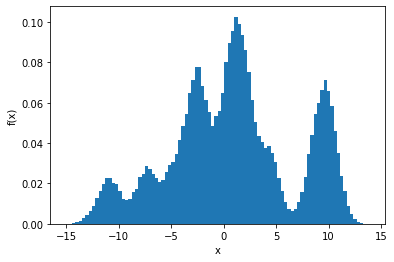

In [7]:
plt.hist(data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

# Step 2: The traditional EM algorithm
The algorithm includes finding the probability of each point belonging to each component, then tune the mean and variance of each component according the the calculated probabilities. 

In [8]:

# First, define a way to calculate pdf 
# This function is actually not used due to its low efficiency. See function calculate_p_matrix below
def pdf(x, input_mean, input_var):
    return math.exp(-0.5 * ((x - input_mean) ** 2 ) / input_var) / (math.sqrt(2 * math.pi * input_var))

# Test the function
assert pdf(0, 0, 1) == 0.3989422804014327
assert pdf(0.5, 0, 1) == 0.3520653267642995


In [9]:
# Using numpy to calculate pdf
# Note that this p matrix is not yet normalised
def calculate_p_matrix(x, input_mean, input_var, input_weight):
    # Duplicate data so dimensions work out
    mean_matrix = np.tile(input_mean, (len(x), 1)).T
    variance_matrix = np.tile(input_var, (len(x), 1)).T
    weight_matrix = np.tile(input_weight, (len(x), 1)).T
    
    # PDF calculation
    p_matrix = weight_matrix * np.exp(-0.5 * np.power(x - mean_matrix, 2) / variance_matrix) / (np.sqrt(2 * np.pi * variance_matrix))
    
    p_matrix = p_matrix.transpose(1, 0)
    
    return p_matrix


In [10]:
# Define a metric to evaluate our return from EM alg.
# Hardcoded P_value to save time

# Old implementation
old_P_value = np.zeros((n,))
for i in range(n):
    for j in range(k):
        old_P_value[i] += weights[j] * pdf(data[i], mean[j], variance[j])


# New implementation with numpy, more efficient
P_value = np.sum(calculate_p_matrix(data, mean, variance, weights), axis = 1)
   
print("new", P_value)
print("old", old_P_value)

new [0.05368566 0.03948393 0.06149196 ... 0.05263488 0.01643724 0.05219745]
old [0.05368566 0.03948393 0.06149196 ... 0.05263488 0.01643724 0.05219745]


In [11]:

# KL divergence is an integral from -inf to +inf, in this case, I only use the n datapoints that we already generated.
# The addition of - P + Q was inspired by scipy's implementation of KL divergence. Apparently, it prevents KL divergence from going negative
def KL_div(pred_mean, pred_variance, pred_weights):
    # Old implementation
    """KL_divergence = 0
    for i in range(n):
        Q_value = 0
        for j in range(k):
            Q_value += pred_weights[j] * pdf(data[i], pred_mean[j], pred_variance[j])
            #P_value += weights[j] * pdf(data[i], mean[j], variance[j])
        KL_divergence += P_value[i] * math.log(P_value[i]/Q_value, math.e) - P_value[i] + Q_value"""
    
    
    # New implementation
    Q_value = np.sum(calculate_p_matrix(data, pred_mean, pred_variance, pred_weights), axis = 1)
    
    KL_divergence = np.sum(P_value * np.log(P_value / Q_value) - P_value + Q_value)
    
    return KL_divergence
    
assert KL_div(mean, variance, weights) == 0



In [48]:
# This implementation is based on Dr. Martha White's notes for CMPUT367, page 107. 

"""scaling_factor_plot = [[] for j in range(k)]
print(scaling_factor_plot)
"""


# Starts with random means, variances and weights
predicted_mean_traditional = np.random.uniform(low=-5, high=5, size=(k, ))
predicted_variance_traditional = np.random.uniform(low=0.5, high=5, size=(k, ))
predicted_weights_traditional = np.random.random(size=(k, ))
predicted_weights_traditional = predicted_weights_traditional / np.sum(predicted_weights_traditional) #normalising

def traditional_EM():

    
    global predicted_mean_traditional, predicted_variance_traditional, predicted_weights_traditional
    divergence_plot = [] # Array for plotting later
    counter = 0 # Count iteration for printing divergence
    
    KL_divergence = KL_div(predicted_mean_traditional, predicted_variance_traditional, predicted_weights_traditional)
    print("kl div:", KL_divergence)
    prev_divergence = math.inf
    
    
    
    while prev_divergence - KL_divergence > 0.0001 and KL_divergence > 0:
        
        # This is the old implementation using python loops. I need to redo this part in numpy to optimise bc it takes too much time.
        """for i in range(n):
            denominator_sum = 0
            for j in range(k):
                probability_matrix[i, j] = predicted_weights[j] * pdf(data[i], predicted_mean[j], predicted_variance[j])
            
            denominator_sum = np.sum(probability_matrix[i, :])
            
            probability_matrix[i, :] = probability_matrix[i, :] / denominator_sum"""
        
        probability_matrix = calculate_p_matrix(data, predicted_mean_traditional, predicted_variance_traditional, predicted_weights_traditional)
        # Normalise
        probability_matrix = probability_matrix / np.sum(probability_matrix, axis = 1, keepdims=True)
        
        """for j in range(k):
            normalised_p_matrix[:, j] = probability_matrix[:, j] / np.sum(probability_matrix[:, j])
            scaling_factor_plot[j].append(np.sum(probability_matrix[:, j]))"""
            
        normalised_p_matrix = probability_matrix / np.sum(probability_matrix, axis = 0, keepdims=True)
        
        
        # Maximisation step
        predicted_weights_traditional = (1/n) * np.sum(probability_matrix, axis = 0)
        
        mean_matrix = (data * normalised_p_matrix.T).T
        predicted_mean_traditional = np.sum(mean_matrix, axis = 0)

        predicted_variance_traditional = np.sum(np.multiply(np.power(np.tile(data, (k, 1)).T - predicted_mean_traditional, 2), normalised_p_matrix), axis = 0)
        
        KL_divergence = KL_div(predicted_mean_traditional, predicted_variance_traditional, predicted_weights_traditional)
        diff = prev_divergence - KL_divergence
        prev_divergence = KL_divergence
        
        
        if counter % 15 == 0:
            print("kl div:", KL_divergence, " |  iter:", counter, " |  difference vs the prev iter:", diff)
            
            
        divergence_plot.append(KL_divergence)
        counter += 1
    return divergence_plot



In [37]:
# Will take abt 5 to 10 minutes to run and converge
divergence_plot = traditional_EM()

kl div: 4992.943978596957
kl div: 369.5442410567829  |  iter: 0  |  difference vs the prev iter: inf
kl div: 17.762757890513186  |  iter: 15  |  difference vs the prev iter: 1.2469995211912739
kl div: 14.359193039645737  |  iter: 30  |  difference vs the prev iter: 0.07493523091533838
kl div: 13.18962460086902  |  iter: 45  |  difference vs the prev iter: 0.08061330245108067
kl div: 12.06139458553501  |  iter: 60  |  difference vs the prev iter: 0.07541740590335166
kl div: 9.96124241553871  |  iter: 75  |  difference vs the prev iter: 0.22126104166559735
kl div: 5.6015033314351985  |  iter: 90  |  difference vs the prev iter: 0.21387362948400934
kl div: 4.165918142203799  |  iter: 105  |  difference vs the prev iter: 0.054144417019707625
kl div: 3.638549051716853  |  iter: 120  |  difference vs the prev iter: 0.027473923093431107
kl div: 3.3149016121443906  |  iter: 135  |  difference vs the prev iter: 0.018413914143888377
kl div: 3.0821381266669206  |  iter: 150  |  difference vs the 

In [38]:
print("----- TARGET DISTRIBUTION ------")
for i in range(k):
    print("component mean:", mean[i], "| variance:", variance[i], "| weight:", weights[i])

print("----- LEARNED DISTRIBUTION ------")
for i in range(k):
    print("component mean:", predicted_mean_traditional[i], "| variance:", predicted_variance_traditional[i], "| weight:", predicted_weights_traditional[i])

----- TARGET DISTRIBUTION ------
component mean: 0.23484192983389285 | variance: 0.806138334815591 | weight: 0.05842010928112557
component mean: 4.520703903089217 | variance: 0.8288370150881301 | weight: 0.07359743358779006
component mean: 1.3534705511446887 | variance: 0.9214828278260032 | weight: 0.07295366312387491
component mean: 8.794798011982436 | variance: 1.1315495190353708 | weight: 0.07421590177622711
component mean: 1.5276732591094184 | variance: 1.250020468371319 | weight: 0.06395399627190505
component mean: 9.895898640289744 | variance: 0.9189143726678921 | weight: 0.06785353366275293
component mean: -10.861123704876732 | variance: 1.3393581064881848 | weight: 0.062241815868367065
component mean: -4.6841406665581395 | variance: 1.069109921014914 | weight: 0.06728586500252656
component mean: 1.057929612921738 | variance: 1.3613678304628372 | weight: 0.06409725842039302
component mean: -2.5882365489502703 | variance: 1.0017266604961792 | weight: 0.06472799763588905
component

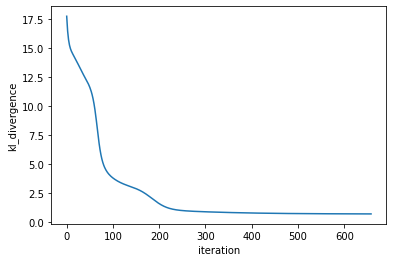

In [39]:
plt.plot([i for i in range(len(divergence_plot[15:]))], divergence_plot[15:])
plt.xlabel("iteration")
plt.ylabel("kl_divergence")
plt.show()


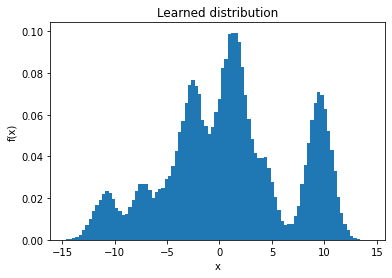

In [40]:
learned_mixture_index = np.random.choice(k, size = n, replace = True, p = predicted_weights_traditional)
learned_data = np.fromiter((np.random.normal(loc = predicted_mean_traditional[index], scale = np.sqrt([predicted_variance_traditional[index]])[0]) for index in learned_mixture_index), float)
assert data.shape == (n, )

plt.hist(learned_data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Learned distribution")
plt.show()

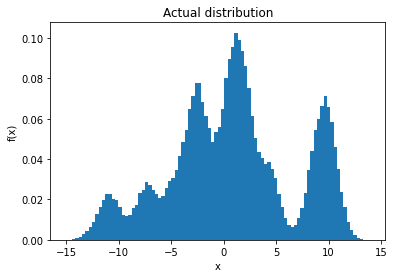

In [41]:
plt.hist(data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Actual distribution")
plt.show()

# Dynamic-update EM

The traditional EM algorithm needs all the datapoint before making any changes to the weights, means and variances. From the idea of reinforcement learning, what if we update every time we see a datapoint (or a batch of datapoints)? In RL, dynamic programming value update will speed up the covergence rate significantly, and is proven to be an unbiased estimator of the actual value function. 

# 2a. Constant stepsize 
Currently, it is not converging. I have not figured out why.

In [49]:
predicted_mean_dynamic = np.random.uniform(low=-5, high=5, size=(k, ))
predicted_variance_dynamic = np.random.uniform(low=0.5, high=5, size=(k, ))
predicted_weights_dynamic = np.random.random(size=(k, ))
predicted_weights_dynamic = predicted_weights_dynamic / np.sum(predicted_weights_dynamic) 
def dynamicEM():
    global predicted_mean_dynamic, predicted_variance_dynamic, predicted_weights_dynamic
    divergence_plot = [] # Array for plotting later
    counter = 0 # Count iteration for printing divergence
    
    KL_divergence = KL_div(predicted_mean_dynamic, predicted_variance_dynamic, predicted_weights_dynamic)
    print("kl div:", KL_divergence)
    prev_divergence = math.inf
    
    stepsize = 0.001

    while True:#prev_divergence - KL_divergence > 0.0001 and KL_divergence > 0:
        
        for i in range(n):
            p_matrix = calculate_p_matrix(np.array([data[i]]), predicted_mean_dynamic, predicted_variance_dynamic, predicted_weights_dynamic)
            p_matrix = p_matrix / np.sum(p_matrix, axis = 1, keepdims=True)
           

            predicted_weights_dynamic = (1/n) * np.sum(p_matrix, axis = 0) + predicted_weights_dynamic
            
            predicted_mean_dynamic = stepsize * p_matrix * data[i] + predicted_mean_dynamic

            predicted_variance_dynamic = stepsize * p_matrix * np.power(predicted_mean_dynamic - data[i], 2) + predicted_variance_dynamic
            
            
        KL_divergence = KL_div(predicted_mean_dynamic, predicted_variance_dynamic, predicted_weights_dynamic)
        
        diff = prev_divergence - KL_divergence
        prev_divergence = KL_divergence
        
        if counter % 1 == 0:
            print("kl div:", KL_divergence, " |  iter:", counter, " |  difference vs the prev iter:", diff)
            
            
        divergence_plot.append(KL_divergence)
        counter += 1
    return divergence_plot


divergence_plot = dynamicEM()

kl div: 7002.70958225662
kl div: 2426.3816896894637  |  iter: 0  |  difference vs the prev iter: inf
kl div: 2906.281951508175  |  iter: 1  |  difference vs the prev iter: -479.90026181871144
kl div: 3237.492171117249  |  iter: 2  |  difference vs the prev iter: -331.2102196090741
kl div: 3386.8102293791867  |  iter: 3  |  difference vs the prev iter: -149.3180582619375


KeyboardInterrupt: 